**Group information**

| Family name | First name | Email address |
| ----------- | ---------- | ------------- |
|             |            |               |
|             |            |               |
|             |            |               |

# Semantic segmentation - Practice

This tutorial explores how to extract automatically building footprints from aerial images. We want to approximate the function mapping input images to a binary prediction for each pixel (i.e. semantic segmentation) using the U-Net convolutional network architecture [(Ronneberger et al. 2015)](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). For this assignment, the GPU implementation of TensorFlow is recommended.

The image data consists of 3347 colour raster of dimension 256x256x3 using the NAD83 (EPSG:26986) projection system. Each raster represents an area of 300 square meters in the state of Massachusetts. The label data consists of building footprints vectors extracted from [OpenStreetMap](https://www.openstreetmap.org/relation/61315) and converted into a binary raster with the same extent and resolution as the image rasters. The unformatted data was provided by Minh (2013) and can be accessed on his [website](http://www.cs.toronto.edu/~vmnih/data/). Images and labels are randomly partitioned into a training (70%) validation (15%) and test sample (15%).

Tensorflow Keras documentation:
- [Convolution](https://keras.io/api/layers/convolution_layers/)
- [Activation](https://keras.io/api/layers/activations/)
- [Pooling](https://keras.io/api/layers/pooling_layers/)
- [Regularisation](https://keras.io/api/layers/regularization_layers/)
- [Optimisers](https://keras.io/api/optimizers/)
- [Metrics](https://keras.io/api/metrics/)
- [Losses](https://keras.io/api/losses/)
- [Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)

![U-Net model](https://www.dropbox.com/scl/fi/wgvqiix6scbm1c983ephk/segmentation_model.jpg?rlkey=71blfq7cm1yzw26puu4l0ybhs&dl=1)

In [16]:
# Packages
import numpy as np
import tensorflow
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

from segmentation_utilities import *
from tensorflow.keras import callbacks, layers, losses, metrics, models, optimizers, preprocessing, utils
from urllib import request

# Working directory
os.chdir(os.path.dirname("C:/Users/bakwe/Desktop/BSE"))

# Checks tensorFlow
print('TensorFlow version:', tensorflow.__version__)
print('GPU available:', len(tensorflow.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.1
GPU available: 0


In [17]:
# Utilities
def download_data() -> None:
    '''Downloads data folder'''
    request.urlretrieve('https://www.dropbox.com/scl/fo/s84ncdd29jokky00b5kwb/ABF1sS8NIhilM1N1-CF8w7Y?rlkey=si6j7dy9eg2mq0mwid2ytd53l&dl=1', 'data.zip')
    shutil.unpack_archive('data.zip', 'data')
    os.remove('data.zip')    
    os.chdir('data')

# Defines paths
paths = dict(
    images_train='training/images',
    labels_train='training/labels',
    images_valid='validation/images',
    labels_valid='validation/labels',
    images_test= 'test/images',
    labels_test= 'test/labels'
)

1. Load the images and labels for the training and validation samples as separate `numpy.ndarray` of dimensions $n \times h \times w \times d$. You can use the provided `search_files` and `read_raster` utility functions. Normalise the images between 0 and 1 and set the labels data type as float.

In [18]:
# Loads dataset
#download_data() # On first execution

QUESTION: Why does using relative filepaths in the below not work? How to sync this with the paths dictionary above?

QUESTION: Why does noramlising by dividing by 255 not work, but normalising the "traditional" way does?

Note that we also load the test data at this point as it is used later in the exercise

In [19]:
#path_folders = {
#    'train_images': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/training/images", '.tif$'),
#    'train_labels': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/training/labels", '.tif$'),
#    'val_images': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/validation/images", '.tif$'),
#    'val_labels': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/validation/labels", '.tif$'),
#    'test_images': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/test/images", '.tif$'),
#    'test_labels': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/test/labels", '.tif$')
#}

# Dictionary to store different arrays
#data = {}
    
#for folder_name, paths in path_folders.items():
#    images = []
#    # Iterate over image paths in the current folder
#    for path in paths:
#        image = read_raster(path)
#        # Check if the folder contains images or labels
#        if 'images' in folder_name:
#            # Normalize the image data
#            image = image / 255.0
#        images.append(image)
#    # Store the data in the data dictionary as a np.array
#    data[folder_name] = np.array(images)

In [20]:
# Extract data from dictionary - convert labels to float
#train_images = data['train_images']
#train_labels = data['train_labels'].astype(np.float64)
#val_images = data['val_images']
#val_labels = data['val_labels'].astype(np.float64)
#test_images = data['test_images']
#test_labels = data['test_labels'].astype(np.float64)

In [21]:
# path_folders = {
#     'train_images': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/training/images", '.tif$'),
#     'train_labels': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/training/labels", '.tif$'),
#     'val_images': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/validation/images", '.tif$'),
#     'val_labels': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/validation/labels", '.tif$'),
#     'test_images': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/test/images", '.tif$'),
#     'test_labels': search_files("C:/Users/gatla/OneDrive/BSE/Image_analysis/segmentation_practice/data/test/labels", '.tif$')
# }

path_folders = {
    'train_images': search_files("C:/Users/bakwe/Desktop/BSE/data/training/images", '.tif$'),
    'train_labels': search_files("C:/Users/bakwe/Desktop/BSE/data/training/labels", '.tif$'),
    'val_images': search_files("C:/Users/bakwe/Desktop/BSE/data/validation/images", '.tif$'),
    'val_labels': search_files("C:/Users/bakwe/Desktop/BSE/data/validation/labels", '.tif$'),
    'test_images': search_files("C:/Users/bakwe/Desktop/BSE/data/test/images", '.tif$'),
    'test_labels': search_files("C:/Users/bakwe/Desktop/BSE/data/test/labels", '.tif$')
}

# Dictionary to store different arrays
data = {}
    
for folder_name, paths in path_folders.items():
    images = []
    # Iterate over image paths in the current folder
    for path in paths:
        image = read_raster(path)
        images.append(image)
    # Store the data in the data dictionary as a np.array
    data[folder_name] = np.array(images)

In [22]:
# Extract data from dictionary - convert labels to float
train_images = data['train_images']
train_labels = data['train_labels'].astype(np.float32)
val_images = data['val_images']
val_labels = data['val_labels'].astype(np.float32)
test_images = data['test_images']
test_labels = data['test_labels'].astype(np.float32)

# Normalise images
# Find the minimum and maximum values for each channel across all patches
min_train = np.min(train_images, axis=(0, 1, 2), keepdims=True)
max_train = np.max(train_images, axis=(0, 1, 2), keepdims=True)

# Normalize the array
train_images = (train_images - min_train) / (max_train - min_train)


# Find the minimum and maximum values for each channel across all patches
min_val = np.min(val_images, axis=(0, 1, 2), keepdims=True)
max_val = np.max(val_images, axis=(0, 1, 2), keepdims=True)

# Normalize the array
val_images = (val_images - min_val) / (max_val - min_val)


# Find the minimum and maximum values for each channel across all patches
min_test = np.min(test_images, axis=(0, 1, 2), keepdims=True)
max_test = np.max(test_images, axis=(0, 1, 2), keepdims=True)

# Normalize the array
test_images = (test_images - min_test) / (max_test - min_test)

2. For the training and validation samples, check the dimensions of the images and labels arrays. Display several matching image and label pairs to ensure correspondence. You can use the provided `compare` utility function.

In [23]:
# Checking dimensions 
print("Train images dimensions: " + str(train_images.shape))
print("Train labels dimensions: " + str(train_labels.shape))
print("Validation images dimensions: " + str(val_images.shape))
print("Validation labels dimensions: " + str(val_labels.shape))

Train images dimensions: (234, 256, 256, 3)
Train labels dimensions: (234, 256, 256, 1)
Validation images dimensions: (50, 256, 256, 3)
Validation labels dimensions: (50, 256, 256, 1)


Rather than using the compare function, we build our own function that efficiently compares three random images and labels with the same indicies.

In [24]:
# Function to display three random patches and their normalized versions
def display_random_images(images, labels):
    # Get the total number of patches
    num_patches = images.shape[0]
    
    # Select three random indices
    random_indices = np.random.choice(num_patches, 3, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))

    for i, idx in enumerate(random_indices):
        # Original patches
        axes[0, i].imshow(images[idx])
        axes[0, i].set_title(f'Image {idx}')
        axes[0, i].axis('off')
        
        # Normalized patches
        axes[1, i].imshow(labels[idx])
        axes[1, i].set_title(f'Label {idx}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

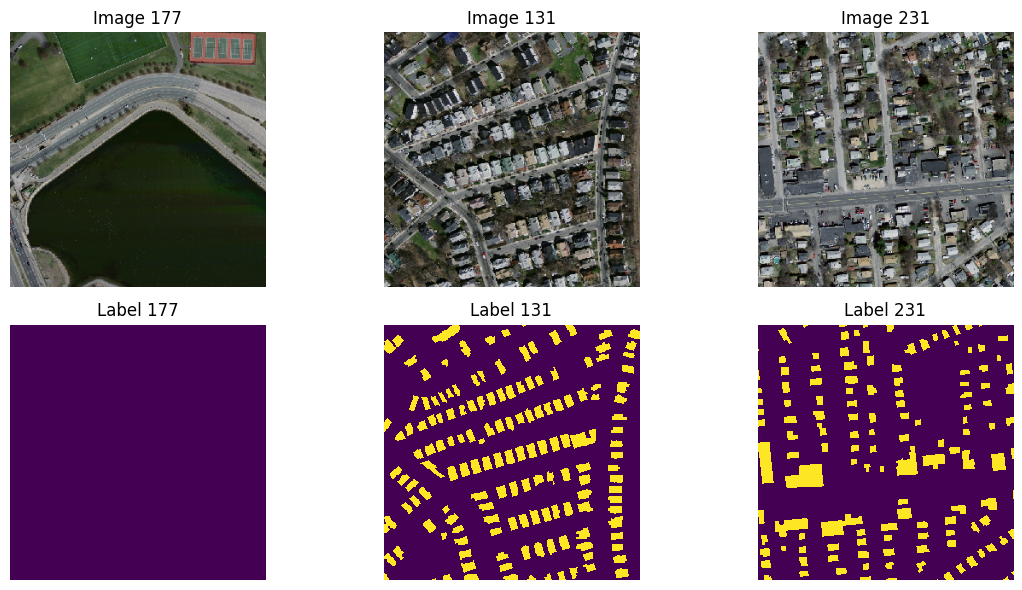

In [25]:
# Display train images and labels
display_random_images(train_images, train_labels)

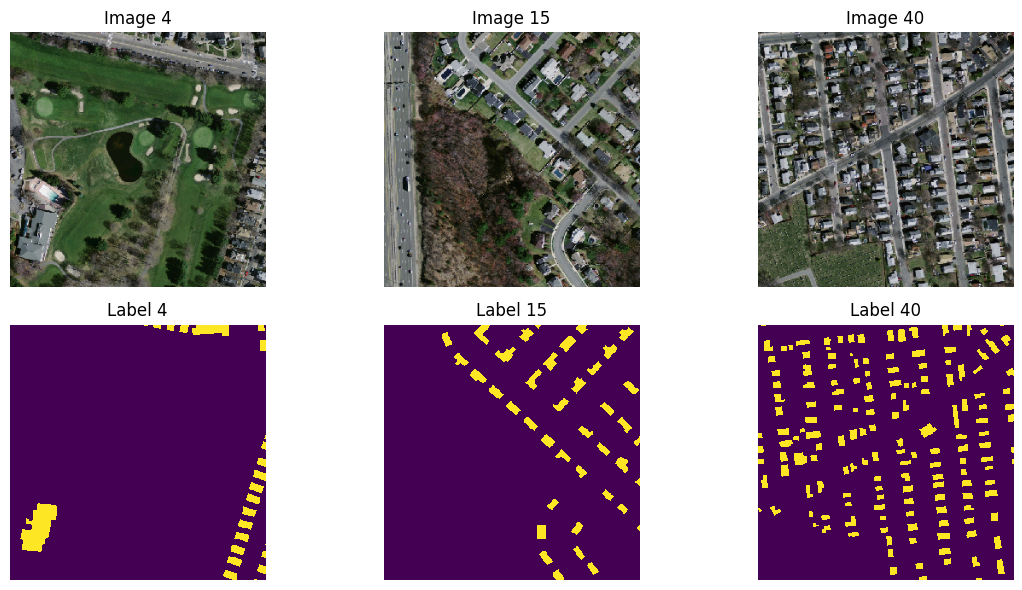

In [26]:
# Display validation images and labels
display_random_images(val_images, val_labels)

Analysing the above images it is clear we have correspondance between our images and labels in both the train and validation data.

3. Using the Keras functional API, define a simplified U-Net model with the number of kernels indicated in the figure above (i.e. 8, 16, 32, 64, 128, ...). There are numerous implementation examples of U-Nets using Keras. Choose the appropriate activation functions for the hidden layers and the output layer, and the corresponding parameter initialisation method.

QUESTION: If 3D kernel doesn't relate to the dimensions of the filters, what does the 3D relate to?

QUESTION: We never need to specify the filter depth? It's implicit within the model?

TO DO: Check and understand acitvation functions and parameter initialisation in the below

TO DO: Check the structure of the de-coder blocks

QUESTION: Why is the transpose kernel 2x2?

In [27]:
# Define U-Net model

# Input
inputs = layers.Input((256,256,3))

# Encoder block 1
conv1 = layers.Conv2D(8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
conv1 = layers.Conv2D(8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

# Encoder block 2
conv2 = layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

# Encoder block 3
conv3 = layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

# Encoder block 4
conv4 = layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
pool4 = layers.MaxPooling2D(pool_size=(2,2))(conv4)

# Encoder block 5 - bottleneck
conv5 = layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
conv5 = layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

# Decoder block 1
up1 = layers.Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same')(conv5)
merge1 = layers.concatenate([conv4, up1], axis=3)
conv6 = layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge1)
conv6 = layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

# Decoder block 2
up2 = layers.Conv2DTranspose(32, 2, strides=(2, 2), activation='relu', padding='same')(conv6)
merge2 = layers.concatenate([conv3, up2], axis=3)
conv7 = layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge2)
conv7 = layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

# Decoder block 3
up3 = layers.Conv2DTranspose(16, 2, strides=(2, 2), activation='relu', padding='same')(conv7)
merge3 = layers.concatenate([conv2, up3], axis=3)
conv8 = layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge3)
conv8 = layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

# Decoder block 4
up4 = layers.Conv2DTranspose(8, 2, strides=(2, 2), activation='relu', padding='same')(conv8)
merge4 = layers.concatenate([conv1, up4], axis=3)
conv9 = layers.Conv2D(8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge4)
conv9 = layers.Conv2D(8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

# Outputs
outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

4. Initialise and compile the model using the chosen optimisation algorithm and the appropriate loss function. Optionally, you can use the focal version of the loss function to account for the class imbalance in the training data. Print the model structure using the `summary` method.

QUESTION: What is the focal version of the loss function?

QUESTION: What metrics are best for a model like this? Should we be using image segmentation metrics like IoU?

TO DO: Look into exactly what binary crossentropy is

TO DO: Add a chart above showing how bad the class imbalance is.

We use the focal binary crossentropy loss function to deal with the heavy class imbalance we have in the data. We also add the F1 score as a metric into our model, as it gives us a better representation of how the model is performing than accuracy alone.

In [28]:
model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss=losses.BinaryFocalCrossentropy(), metrics=['accuracy', metrics.Precision(), metrics.Recall()])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        224 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │        584 │ conv2d[0][0]      │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      1,168 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     32,832 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_7[0][0], 

 Total params: 485,817 (1.85 MB)

 Trainable params: 485,817 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

5. Estimate the model parameters using the training and the validation sample. Use batch-size of 32 and a maximum of 30 training epoch. Use an early-stopping callback with a patience parameter of 3 to recover the parameters that minimise the error on the validation sample.

QUESTION: Under the epochs, I thought the number related to the number of obsevrations, but here it clearly doesn't, so what does it mean?

In [29]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_images, train_labels, batch_size=32, epochs=30, 
                    validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4822 - loss: 0.1737 - precision: 0.1186 - recall: 0.5577 - val_accuracy: 0.8691 - val_loss: 0.1606 - val_precision: 0.2043 - val_recall: 0.0029
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 913ms/step - accuracy: 0.8792 - loss: 0.1426 - precision: 0.1796 - recall: 0.0018 - val_accuracy: 0.8700 - val_loss: 0.1232 - val_precision: 0.1835 - val_recall: 3.0325e-04
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 917ms/step - accuracy: 0.8913 - loss: 0.1145 - precision: 0.1802 - recall: 2.7912e-04 - val_accuracy: 0.8702 - val_loss: 0.1149 - val_precision: 0.2479 - val_recall: 7.0523e-05
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 919ms/step - accuracy: 0.8960 - loss: 0.1020 - precision: 0.1836 - recall: 6.3043e-05 - val_accuracy: 0.8702 - val_loss: 0.1046 - val_precision: 0.1667 - val_recall: 4.7016e-06
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8850 - loss: 0.0965 - precision: 0.3013 - recall: 3.0385e-06 - val_accuracy: 0.8702 - val

6. Display the evolution of the training and validation metrics during training using the provided `display_history` utility function. Load and format the test sample (see question 1) and evaluate the model's generalisation performance.

In [31]:
# Ollie, we will need your utilities in the git=)
# display_history(history.history, metrics=['accuracy', 'loss'], number_metrics=2, figsize=(10,5))

Test data was loaded above with the other data

In [33]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print(f'Test Loss: {test_loss}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test Accuracy: {test_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8984 - loss: 0.0657 - precision: 0.6003 - recall: 0.0016
Test Loss: 0.06389552354812622
Test Precision: 0.5799522399902344
Test Recall: 0.0015151468105614185
Test Accuracy: 0.902152419090271


7. Compute the predicted probabilities for the test images. Turn the probabilities into binary predictions using a threshold of 0.5. Display prediction statistics using the provided `display_statistics` utility for several test images.

In [34]:
# Predict probas
predict_probs = model.predict(test_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step


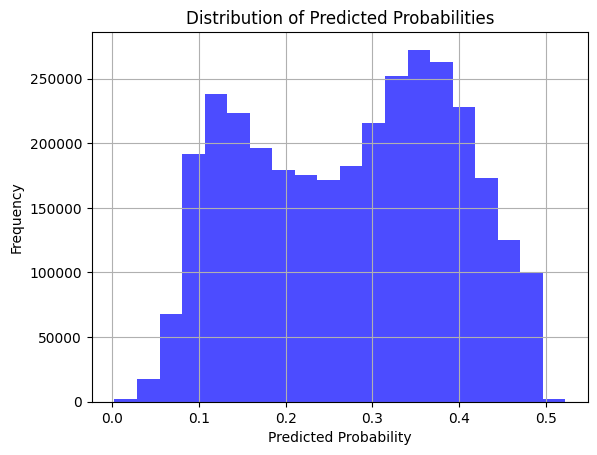

In [35]:
# Flatten the array

proba_predict_flat = predict_probs.flatten()

# Plot histogram
plt.hist(proba_predict_flat, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [36]:
# Turn predictions to binary with a 0.5 threshold
binary_predictions = (predict_probs >= 0.5).astype(int)

TO DO: Once model is working better, display below images for several examples

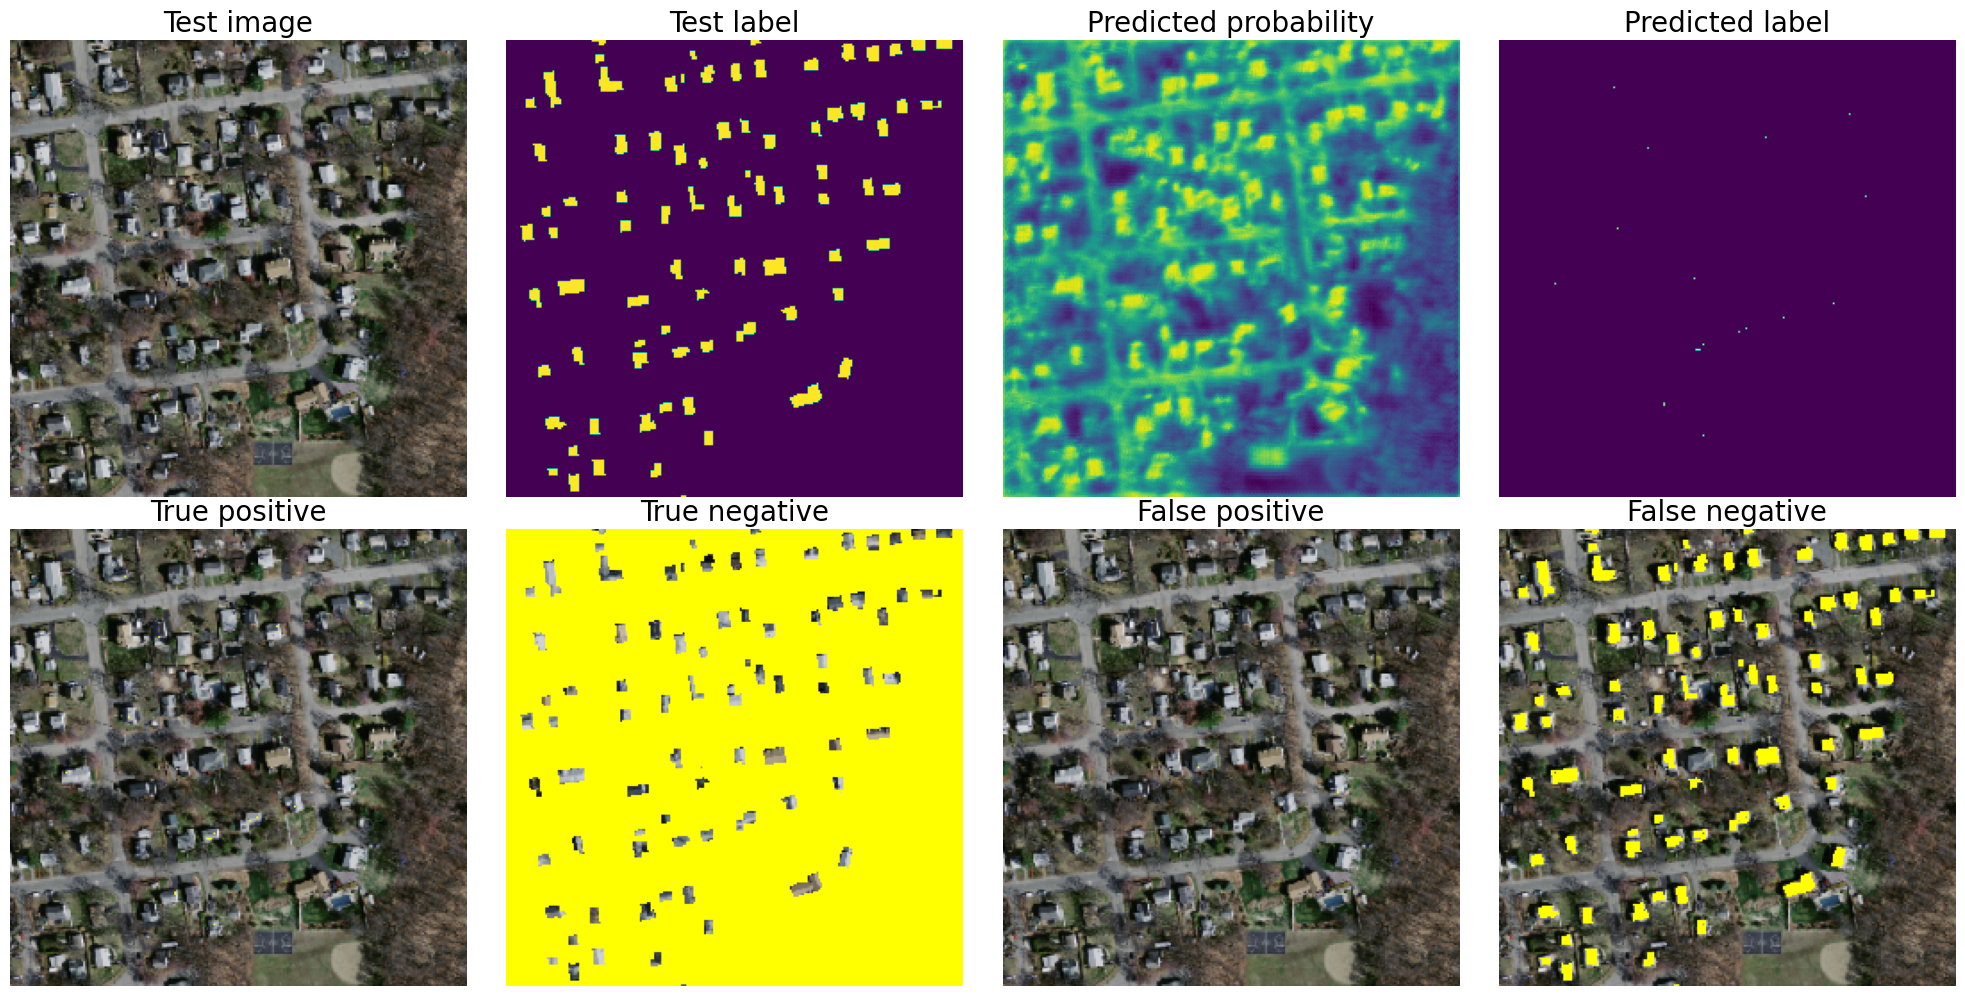

In [37]:
display_statistics(test_images[5], test_labels[5], predict_probs[5], binary_predictions[5])

POTENTIAL TO DO: Put metrics in a graph for easy comparison across models.

To understand the classification performance better, we can create a confusion matrix and caluculate some evaluation metrics (Precision, Recall, F1, IoU) across all images.

TO DO: Add Classification report

False Positives: 352
False Negatives: 320275
Precision: 0.5799522673031027
Recall: 0.0015151467915363777
F1: 0.0030223974577035374
IoU: 0.00151348568033427


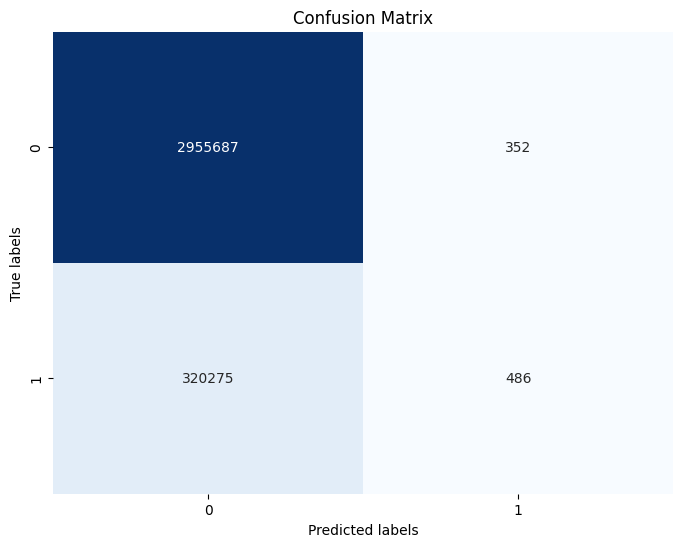

In [38]:
# Flatten the arrays
labels_flat = test_labels.reshape(-1)
predictions_flat = binary_predictions.reshape(-1)

# Compute confusion matrix
conf_matrix = confusion_matrix(labels_flat, predictions_flat)

# Extract values from confusion matrix
true_negatives = conf_matrix[0, 0]
false_positives = conf_matrix[0, 1]
false_negatives = conf_matrix[1, 0]
true_positives = conf_matrix[1, 1]

# Print classification metrics
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"Precision: {precision_score(labels_flat, predictions_flat)}")
print(f"Recall: {recall_score(labels_flat, predictions_flat)}")
print(f"F1: {f1_score(labels_flat, predictions_flat)}")
m = metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
m.update_state(test_labels, predict_probs)
print(f"IoU: {m.result().numpy()}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The model doesn't appear to work very well at this threshold. However, looking at the predicted probability images, the model does seem to be reflecting the images somewhat accurately. We will use a ROC curve and a precision and recall curve to try and find the optimal threshold for our model.

8. Assuming that we give equal importance to reducing false positives and false negatives, use a decision probability threshold that strikes the best balance between these two quantities.

In [41]:
# # label_predict is not defined - commented it out so far
# # Compute ROC curve and find the optimal threshold
# fpr, tpr, thresholds = roc_curve(label_predict, predict_probs.ravel())
# optimal_idx = np.argmin(np.sqrt(fpr*2 + (1-tpr)*2))
# optimal_threshold = thresholds[optimal_idx]
# print(f'Optimal ROC Threshold: {optimal_threshold}')

# auc_score = roc_auc_score(label_predict, predict_probs.ravel())

# # Compute Precision-Recall curve and find the optimal threshold
# precision, recall, pr_thresholds = precision_recall_curve(label_predict, predict_probs.ravel())
# pr_auc_score = average_precision_score(label_predict, predict_probs.ravel())
# optimal_pr_idx = np.argmax(2 * precision * recall / (precision + recall + 1e-5))  # F1-score maximization
# optimal_pr_threshold = pr_thresholds[optimal_pr_idx]
# print(f'Optimal PR Threshold: {optimal_pr_threshold}')

# # Plot ROC curve
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.2f}')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.grid(True)

# # Plot Precision-Recall curve
# plt.subplot(1, 2, 2)
# plt.plot(recall, precision, color='green', lw=2, label=f'AP = {pr_auc_score:.2f}')
# plt.scatter(recall[optimal_pr_idx], precision[optimal_pr_idx], color='red', label=f'Optimal Threshold: {optimal_pr_threshold:.2f}')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [42]:
# Define a function to compute binary IoU for class 1 only
def binary_iou(y_true, y_pred):
    y_true = (y_true == 1).astype(np.float32)
    y_pred = (y_pred == 1).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

# Generate thresholds at intervals of 0.01
thresholds = np.arange(0.01, 1.0, 0.01)

# Find the optimal threshold that maximizes binary IoU
ious = []
for threshold in thresholds:
    # Convert probabilities to binary predictions using the current threshold
    label_predict_optimal = (predict_probs.ravel() >= threshold).astype(np.float32)
    
    # Compute binary IoU using the current threshold
    iou = binary_iou(test_labels.ravel(), label_predict_optimal)
    ious.append(iou)

# Find the index of the maximum IoU
optimal_idx = np.argmax(ious)
optimal_threshold = thresholds[optimal_idx]
best_iou = ious[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}, Best Binary IoU: {best_iou}')

# Turn the probabilities into binary predictions using the optimal threshold
label_predict_optimal_iou = (predict_probs >= optimal_threshold).astype(np.float32)

Optimal Threshold: 0.42000000000000004, Best Binary IoU: 0.33711737394332886


Optimal threshold based on IoU optimization is higher than previous metrics, we believe it's intuitive as far it doesn't account for TN count (so basically we do not care, how many TN we get).... STILL TO BE CHANGED
Anyway, we are not going to use this threshold due to several factors related to IoU metrics (as discussed - it's not differentiable, numerically unstable etc).

Our ROC and precision-recall curves suggest a lower threshold of between 0.32 and 0.4 would be better for our model. We will use a threshold of 0.35 as a middle ground of these two.

In [43]:
# Turn predictions to binary with a 0.5 threshold
binary_predictions_optimal = (predict_probs >= 0.35).astype(int)

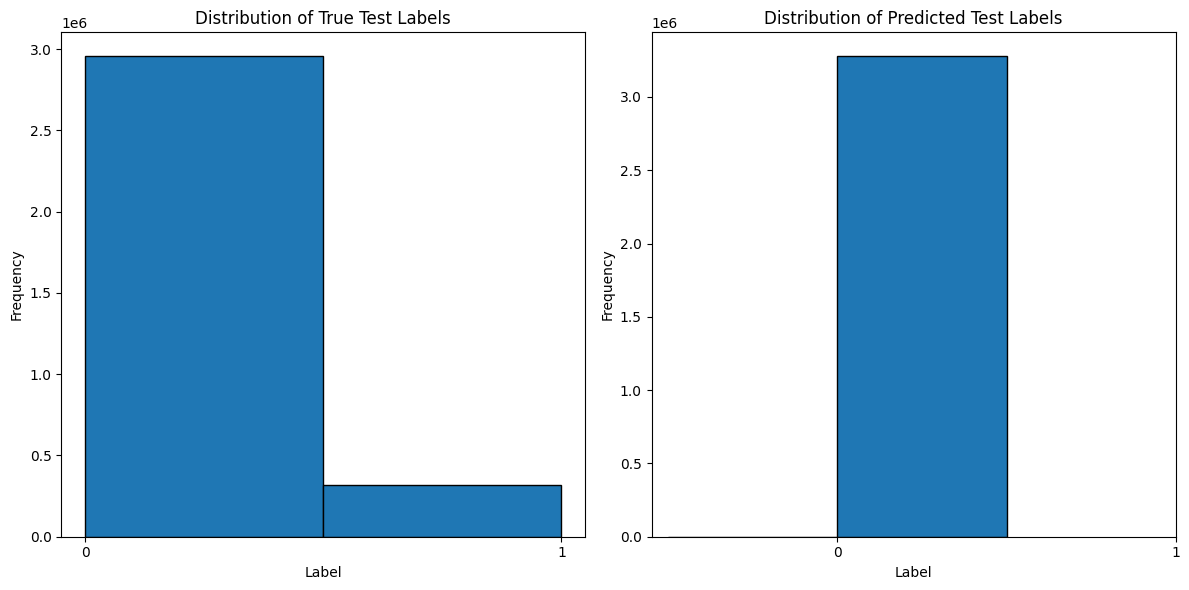

In [44]:
# Flatten the labels to get the distribution of 0s and 1s
labels_test_flat = test_labels.flatten()
labels_predict_flat = label_predict_optimal.flatten()

# Create the figure and set the size
plt.figure(figsize=(12, 6))  # Adjusted size to fit two plots horizontally

# Histogram for the true test labels
plt.subplot(1, 2, 1)  # Adjusted to 1 row, 2 columns
plt.hist(labels_test_flat, bins=2, edgecolor='black')
plt.title('Distribution of True Test Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['0', '1'])

# Histogram for the predicted test labels
plt.subplot(1, 2, 2)  # Adjusted to 1 row, 2 columns
plt.hist(labels_predict_flat, bins=2, edgecolor='black')
plt.title('Distribution of Predicted Test Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['0', '1'])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

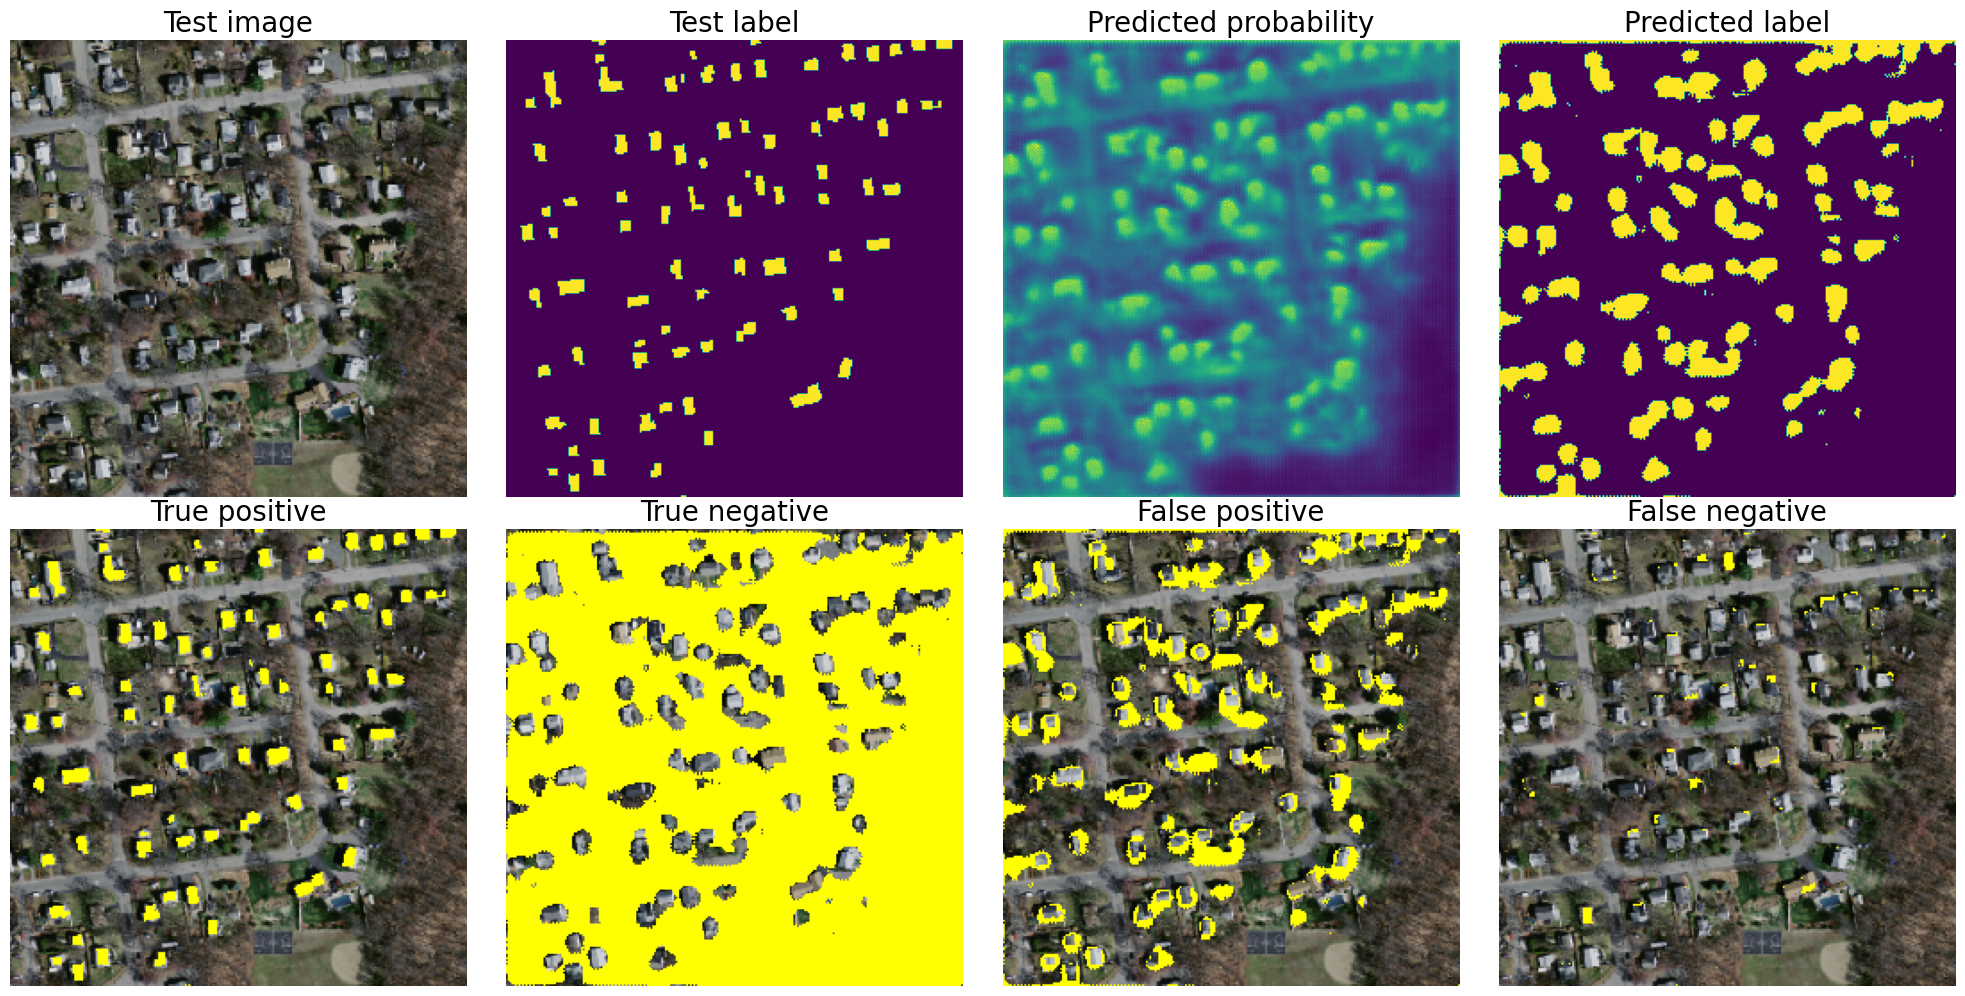

In [ ]:
display_statistics(test_images[5], test_labels[5], predict_probs[5], binary_predictions_optimal[5])

Based on visual analysis, the new threshold seems to lead to better model performance. We will now report the same classification metrics as before.

False Positives: 400287
False Negatives: 75572
Precision: 0.37985765543567845
Recall: 0.7643977915020841
F1: 0.5075131670594274
IoU: 0.340045303106308


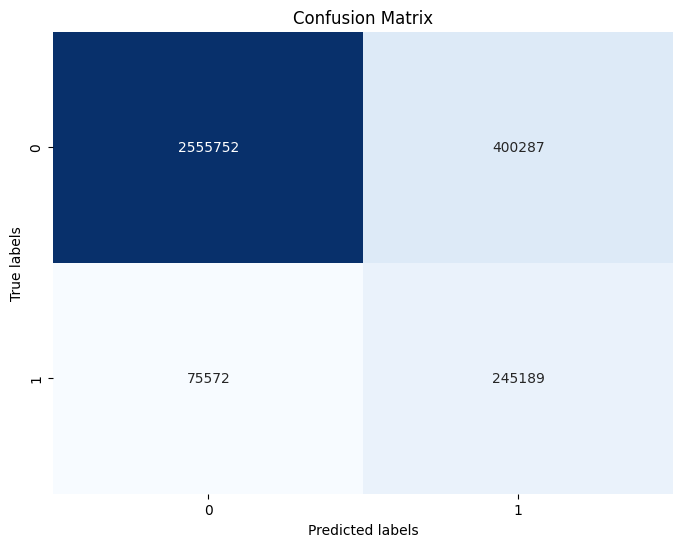

In [ ]:
# Flatten the arrays
predictions_flat = binary_predictions_optimal.reshape(-1)

# Compute confusion matrix
conf_matrix = confusion_matrix(labels_flat, predictions_flat)

# Extract values from confusion matrix
true_negatives = conf_matrix[0, 0]
false_positives = conf_matrix[0, 1]
false_negatives = conf_matrix[1, 0]
true_positives = conf_matrix[1, 1]

# Print classification metrics
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"Precision: {precision_score(labels_flat, predictions_flat)}")
print(f"Recall: {recall_score(labels_flat, predictions_flat)}")
print(f"F1: {f1_score(labels_flat, predictions_flat)}")
m = metrics.BinaryIoU(target_class_ids=[1], threshold=0.35)
m.update_state(test_labels, predict_probs)
print(f"IoU: {m.result().numpy()}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The lower threshold has drastically increased the number of false positives, but also decreased the number of false negatives. (This is tobe expected when lowering a classification threshold). Naturally this means the Precision of the model has dropped, but the Recall has improved significantly, leading to a much improved F1 score overall. The new threshold has alos improved IoU greatly, now at 0.34.

9. **OPTIONAL** Modify the network with either batch-normalisation or spatial dropout layers to increase predictive performance. Alternatively, use image augmentation techniques to increase the robustness of the model.

Along with the above reccomendations, we also increase the number of epochs, as above it appears to model has not converged. We also adjust the IoU threshold in the model to the optimal value found in the model above. Leanring rate 